In [1]:
import pandas as pd
from pandas import read_csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import warnings
warnings.filterwarnings("ignore")

os.chdir('/Users/xiaodanxu/Documents/SynthFirm.nosync')


In [2]:
# conversions
veh_name_remap = {'combination long-haul truck':'combination long-haul truck',
                  'combination short-haul truck': 'combination short-haul truck',
                  'single-unit short-haul truck': 'single unit short-haul truck',
                 'single-unit long-haul truck': 'single unit long-haul truck',
                  'light commercial truck':  'light commercial truck'}

sut_ct_label = {'combination long-haul truck':'combination truck',
                  'combination short-haul truck': 'combination truck',
                  'single unit short-haul truck': 'single unit truck',
                 'single unit long-haul truck': 'single unit truck'}

hauling_label = {'combination long-haul truck':'long-haul',
                  'combination short-haul truck': 'short-haul',
                  'single unit short-haul truck': 'short-haul',
                 'single unit long-haul truck': 'long-haul'}

#age bin related
age_bin = [-1, 3, 5, 7, 9, 14, 19, 31]

age_bin_label = ['age<=3', '3<age<=5','5<age<=7', 
                 '7<age<=9', '9<age<=14', '14<age<=19', 'age>=20']

age_bin_order = {'age<=3':1, '3<age<=5':2, '5<age<=7':3, 
                 '7<age<=9':4, '9<age<=14':5, 
                 '14<age<=19':6, 'age>=20':7}

In [3]:
# load MOVES data
MOVES_data_path = 'RawData/MOVES/MOVES_VMT_fraction_with_fuel_com_only.csv'
MOVES_fleet = read_csv(MOVES_data_path)
print(MOVES_fleet.columns)

# load vius data
vius_data_path = 'RawData/US_VIUS_2021/vius_2021_com_crosswalk_20240419.csv'
vius_fleet = read_csv(vius_data_path)
vius_fleet.head(5)

Index(['sourceTypeID', 'ageID', 'HPMSVtypeID', 'sourceTypeName',
       'HPMSVtypeName', 'sourceTypePopulation', 'ageFraction', 'modelYearID',
       'population_by_year', 'relativeMAR', 'weighted_vmt_rate',
       'vmt_fraction', 'fuelTypeID', 'stmyFraction', 'fuelTypeDesc'],
      dtype='object')


,ID,TABWEIGHT,REGSTATE,ACQUIREYEAR,ACQUISITION,AVGWEIGHT,BRAKES,BTYPE,BUSRELATED,CAB,...,VINTAGE,AGE_BIN,weighted_VMT,VEH_CLASS_4,SHORT_HAUL,RO_GT100,VEH_CLASS_SynthF,VEH_CLASS_SynthFirm,SUT_2B_def,VEH_CLASS_MOVES
0,1,38.5,Montana,2011,Used,"100,001 to 130,000 pounds",Air,Not applicable (see 'Applicable Vehicles'),Some commercial activity,Not applicable (see 'Applicable Vehicles'),...,23,>20 years,247324.0,Class 7-8,0,70.0,HDT,HDT tractor,NaN,Combination long-haul truck
1,2,197.4,North Carolina,Not reported,Used,"60,001 to 80,000 pounds",Air,Not applicable (see 'Applicable Vehicles'),Some commercial activity,Not applicable (see 'Applicable Vehicles'),...,15,15-20 years,9381829.8,Class 7-8,0,60.0,HDT,HDT tractor,NaN,Combination long-haul truck
2,8,182.3,New Jersey,9,Used,"50,001 to 60,000 pounds",Air,Not applicable (see 'Applicable Vehicles'),Some commercial activity,Not applicable (see 'Applicable Vehicles'),...,23,>20 years,6301017.2,Class 7-8,1,0.0,HDT,HDT tractor,NaN,Combination short-haul truck
3,9,85.9,Louisiana,Not reported,Used,"60,001 to 80,000 pounds",Air,Not applicable (see 'Applicable Vehicles'),Some commercial activity,Not applicable (see 'Applicable Vehicles'),...,19,15-20 years,3176839.7,Class 7-8,1,NaN,HDT,HDT tractor,NaN,Combination short-haul truck
4,10,240.2,Ohio,2019,New,"60,001 to 80,000 pounds",Air,Not applicable (see 'Applicable Vehicles'),Some commercial activity,Not applicable (see 'Applicable Vehicles'),...,1,1-3 years,17753662.4,Class 7-8,0,85.0,HDT,HDT tractor,NaN,Combination long-haul truck


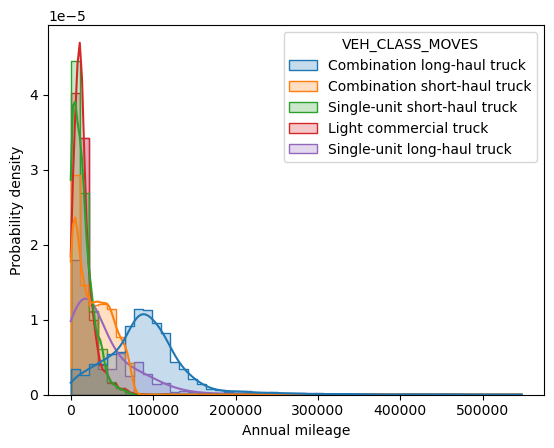

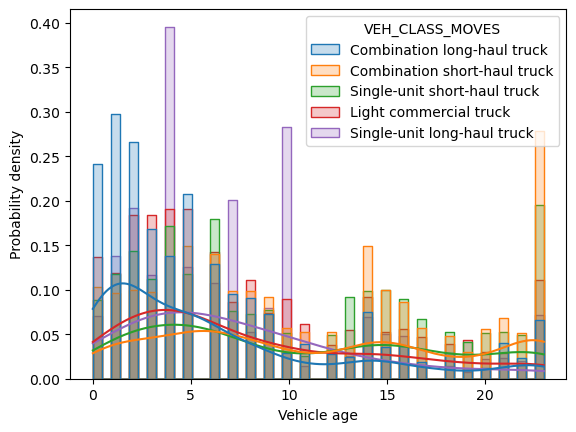

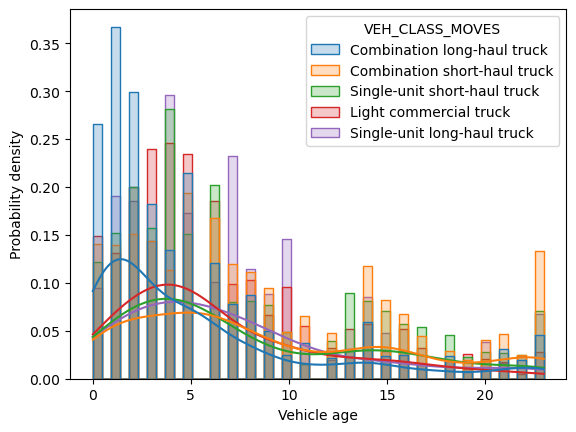

In [4]:
# post-process VIUS data

# weighted VMT
vius_fleet.loc[:, 'WGT_VMT'] = \
vius_fleet.loc[:, 'TABWEIGHT'] * vius_fleet.loc[:, 'MILESANNL']

# vehicle age
vius_fleet.loc[:, 'VEH_AGE'] = \
2021 - vius_fleet.loc[:, 'MODELYEAR']

vius_fleet.loc[:, 'AGE_BIN'] = \
pd.cut(vius_fleet.loc[:, 'VEH_AGE'], 
       bins=age_bin, right=True, labels=age_bin_label)

MOVES_fleet.loc[:, 'AGE_BIN'] = \
pd.cut(MOVES_fleet.loc[:, 'ageID'], 
       bins=age_bin, right=True, labels=age_bin_label)

sns.histplot(data=vius_fleet, 
             x="MILESANNL", weights = 'TABWEIGHT',
             stat = 'density', 
             hue="VEH_CLASS_MOVES", element="step",
             bins = 50, kde = True,
             common_norm = False)
plt.xlabel('Annual mileage')
plt.ylabel('Probability density')
plt.savefig('RawData/MOVES/plot/annual_mileage_VIUS.png', dpi = 300)
plt.show()

sns.histplot(data=vius_fleet, 
             x="VEH_AGE", weights = 'TABWEIGHT',
             stat = 'density', 
             hue="VEH_CLASS_MOVES", element="step",
             bins = 50, kde = True,
             common_norm = False)
plt.xlabel('Vehicle age')
plt.ylabel('Probability density')
plt.savefig('RawData/MOVES/plot/age_distribution_by_count_VIUS.png', dpi = 300)
plt.show()

sns.histplot(data=vius_fleet, 
             x="VEH_AGE", weights = 'WGT_VMT',
             stat = 'density', 
             hue="VEH_CLASS_MOVES", element="step",
             bins = 50, kde = True,
             common_norm = False)
plt.xlabel('Vehicle age')
plt.ylabel('Probability density')
plt.savefig('RawData/MOVES/plot/age_distribution_by_VMT_VIUS.png', dpi = 300)
plt.show()

In [5]:
# check sample size
vius_sample_size_1 = vius_fleet.groupby(['VEH_CLASS_MOVES']).size()
print(vius_sample_size_1)

vius_sample_size_2 = vius_fleet.groupby(['VEH_CLASS_MOVES', 'AGE_BIN']).size()
# vius_sample_size_2

vius_sample_size_3 = vius_fleet.groupby(['VEH_CLASS_MOVES'])['TABWEIGHT'].sum()
print(vius_sample_size_3)

VEH_CLASS_MOVES
Combination long-haul truck      6100
Combination short-haul truck     6513
Light commercial truck           2934
Single-unit long-haul truck      1546
Single-unit short-haul truck    19887
dtype: int64
VEH_CLASS_MOVES
Combination long-haul truck      1057993.1
Combination short-haul truck      968638.8
Light commercial truck          22094830.1
Single-unit long-haul truck       392897.9
Single-unit short-haul truck     4177755.3
Name: TABWEIGHT, dtype: float64


In [5]:
# plot func
def plot_clustered_stacked(dfall, labels, title, ylabelname, H="/", **kwargs):
    """Given a list of dataframes, with identical columns and index, create a clustered stacked bar plot. 
labels is a list of the names of the dataframe, used for the legend
title is a string for the title of the plot
H is the hatch used for identification of the different dataframe"""
    plt.figure(figsize = (6, 5))
    n_df = len(dfall)
    n_col = len(dfall[0].columns) 
    n_ind = len(dfall[0].index)
    axe = plt.subplot(111)

    for df in dfall : # for each data frame
        axe = df.plot(kind="bar",
                      linewidth=0,
                      stacked=True,
                      ax=axe,
                      legend=False,
                      grid=False, cmap= 'plasma_r',
                      **kwargs)  # make bar plots

    h,l = axe.get_legend_handles_labels() # get the handles we want to modify
    for i in range(0, n_df * n_col, n_col): # len(h) = n_col * n_df
        for j, pa in enumerate(h[i:i+n_col]):
            for rect in pa.patches: # for each index
                rect.set_x(rect.get_x() + 1 / float(n_df + 1) * i / float(n_col))
                rect.set_hatch(H * int(i / n_col)) #edited part     
                rect.set_width(1 / float(n_df + 1))

    axe.set_xticks((np.arange(0, 2 * n_ind, 2) + 1 / float(n_df + 1)) / 2.)
    axe.set_xticklabels(df.index, rotation = 0)
    axe.set_title(title)

    # Add invisible data to add another legend
    n=[]        
    for i in range(n_df):
        n.append(axe.bar(0, 0, color="gray", hatch=H * i * 2))

    l1 = axe.legend(h[:n_col], l[:n_col], 
                    bbox_to_anchor=(0.99, 1), loc="upper left", fontsize = 7)
    if labels is not None:
        l2 = plt.legend(n, labels, loc=[1.01, 0.1]) 
    axe.add_artist(l1)
    plt.xticks(rotation = 60, ha = 'right')
    plt.ylabel(ylabelname)
    plt.xlabel('')
    plt.tight_layout()
    
    return axe

# Part 1.1 - truck count comparison and hauling fraction

In [6]:
# compare veh count by MOVES source type

# MOVES_fleet.head(5)
MOVES_count_by_st = \
MOVES_fleet.groupby('sourceTypeName')[['sourceTypePopulation']].mean()
MOVES_count_by_st = MOVES_count_by_st.reset_index()
MOVES_count_by_st['sourceTypeName'] = \
MOVES_count_by_st['sourceTypeName'].str.lower()
print(MOVES_count_by_st['sourceTypeName'].unique())
# MOVES_count_by_st

vius_count_by_st = \
vius_fleet.groupby('VEH_CLASS_MOVES')[['TABWEIGHT']].sum()
vius_count_by_st = vius_count_by_st.reset_index()
vius_count_by_st['VEH_CLASS_MOVES'] = \
vius_count_by_st['VEH_CLASS_MOVES'].str.lower()
vius_count_by_st.loc[:, 'VEH_CLASS_MOVES'] = \
vius_count_by_st.loc[:, 'VEH_CLASS_MOVES'].map(veh_name_remap)

# generate veh count comparison
MOVES_count_by_st.columns = ['Vehicle type', 'Count']
MOVES_count_by_st.loc[:, 'Source'] = 'MOVES'

vius_count_by_st.columns = ['Vehicle type', 'Count']
vius_count_by_st.loc[:, 'Source'] = '2021 US VIUS'

['combination long-haul truck' 'combination short-haul truck'
 'light commercial truck' 'single unit long-haul truck'
 'single unit short-haul truck']


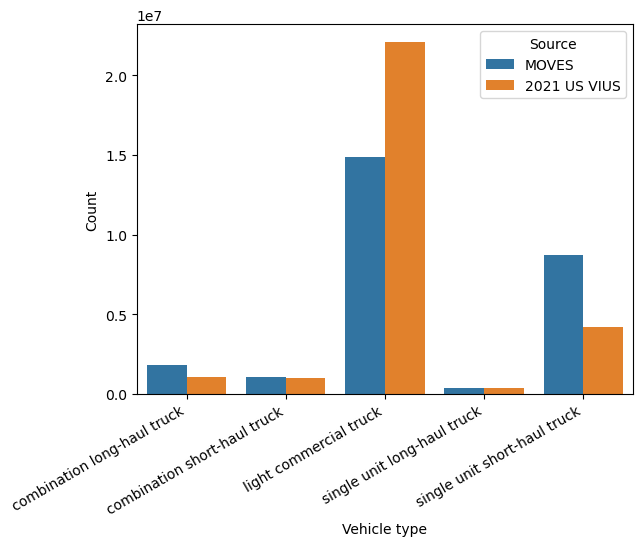

In [7]:
truck_count_comparison = \
pd.concat([MOVES_count_by_st, vius_count_by_st])
# truck_count_comparison = \
# truck_count_comparison.loc[truck_count_comparison["Vehicle type"] != 
# 'light commercial truck']
sns.barplot(truck_count_comparison, 
            x="Vehicle type", y="Count", hue="Source", 
            errorbar = None)
plt.xticks(rotation = 30, ha= 'right')
plt.savefig('RawData/MOVES/plot/truck_count_comparison_by_type.png',
            dpi = 300, bbox_inches = 'tight')
plt.show()

In [9]:
truck_count_comparison.to_csv('RawData/MOVES/MOVES_VIUS_truck_count.csv', index = False)

In [11]:
# plot ST MY distribution
# MOVES_fleet.head(5)
MOVES_fleet_selected = \
MOVES_fleet[['sourceTypeName', 'ageID', 'AGE_BIN', 'population_by_year']]
MOVES_fleet_selected = MOVES_fleet_selected.drop_duplicates(keep = 'first')


MOVES_count_by_stmy = pd.pivot_table(MOVES_fleet_selected, index = 'sourceTypeName',
                                  columns = 'AGE_BIN', values = 'population_by_year',
                                  aggfunc = 'sum')

MOVES_count_by_stmy = MOVES_count_by_stmy.reset_index()
MOVES_count_by_stmy['sourceTypeName'] = \
MOVES_count_by_stmy['sourceTypeName'].str.lower()
print(MOVES_count_by_stmy['sourceTypeName'].unique())
# MOVES_count_by_st

vius_count_by_stmy = pd.pivot_table(vius_fleet, index = 'VEH_CLASS_MOVES',
                                  columns = 'AGE_BIN', values = 'TABWEIGHT',
                                  aggfunc = 'sum')
vius_count_by_stmy = vius_count_by_stmy.reset_index()
vius_count_by_stmy['VEH_CLASS_MOVES'] = \
vius_count_by_stmy['VEH_CLASS_MOVES'].str.lower()
vius_count_by_stmy.loc[:, 'VEH_CLASS_MOVES'] = \
vius_count_by_stmy.loc[:, 'VEH_CLASS_MOVES'].map(veh_name_remap)

vius_count_by_stmy = \
vius_count_by_stmy.rename(columns = {'VEH_CLASS_MOVES': 'sourceTypeName'})


vius_count_by_stmy = vius_count_by_stmy.set_index('sourceTypeName')
MOVES_count_by_stmy = MOVES_count_by_stmy.set_index('sourceTypeName')
# generate veh count comparison
# vius_count_by_stmy.columns = ['Vehicle type', 'Count']
# MOVES_count_by_stmy.loc[:, 'Source'] = 'MOVES'

# vius_count_by_st.columns = ['Vehicle type', 'Count']
# vius_count_by_stmy.loc[:, 'Source'] = 'VIUS'

vius_count_by_stmy.head(5)

['combination long-haul truck' 'combination short-haul truck'
 'light commercial truck' 'single unit long-haul truck'
 'single unit short-haul truck']


AGE_BIN,sourceTypeName,14<age<=19,3<age<=5,5<age<=7,7<age<=9,9<age<=14,age<=3,age>=20
0,combination long-haul truck,63471.3,168087.3,108782.3,79554.2,94869.8,473795.9,69432.3
1,combination short-haul truck,142800.8,100938.4,106501.6,85036.2,154087.9,176792.4,202481.5
2,light commercial truck,2411724.9,3876145.7,2316821.0,1874471.5,3398892.4,6337619.4,1879155.2
3,single unit long-haul truck,24634.9,94211.7,55825.7,23812.0,76296.8,93352.5,24764.3
4,single unit short-haul truck,671298.6,556003.3,491696.2,289863.4,611305.8,887020.5,670567.5


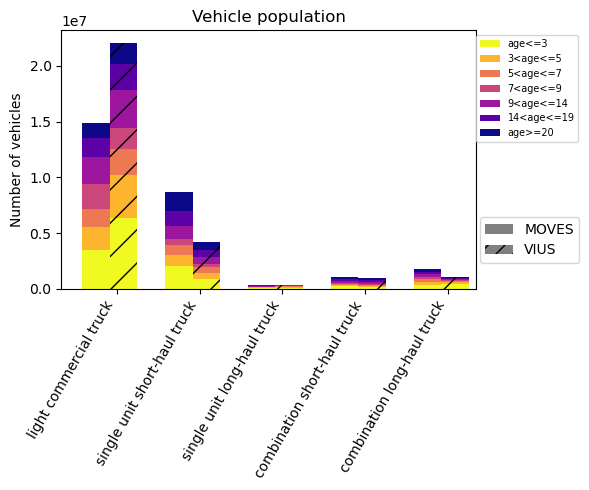

In [13]:
# plot stacked bar chart
order_of_col =  ['light commercial truck', 
                 'single unit short-haul truck',
                 'single unit long-haul truck', 
                 'combination short-haul truck',
                 'combination long-haul truck']  


vius_count_by_stmy = vius_count_by_stmy[age_bin_label]
vius_count_by_stmy = vius_count_by_stmy.loc[order_of_col]

MOVES_count_by_stmy = MOVES_count_by_stmy[age_bin_label]
MOVES_count_by_stmy = MOVES_count_by_stmy.loc[order_of_col]
plot_clustered_stacked([MOVES_count_by_stmy, vius_count_by_stmy],
                       ["MOVES", "VIUS"], 
                       'Vehicle population', 
                       'Number of vehicles')

plt.savefig('RawData/MOVES/plot/truck_count_comparison_by_stmy.png',
            dpi = 300, bbox_inches = 'tight')
plt.show()

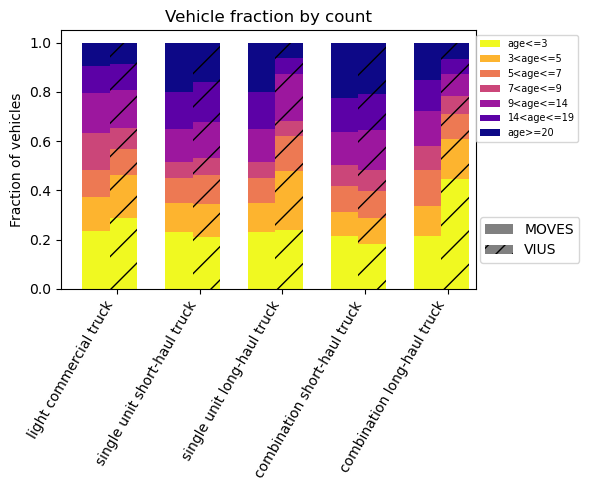

In [14]:
# normalized vehicle plot

vius_count_by_stmy.loc[:, age_bin_label] = \
    vius_count_by_stmy.loc[:, age_bin_label].div(vius_count_by_stmy.loc[:, age_bin_label].sum(axis=1), axis=0)

MOVES_count_by_stmy.loc[:, age_bin_label] = \
    MOVES_count_by_stmy.loc[:, age_bin_label].div(MOVES_count_by_stmy.loc[:, age_bin_label].sum(axis=1), axis=0)

plot_clustered_stacked([MOVES_count_by_stmy, vius_count_by_stmy],
                       ["MOVES", "VIUS"], 
                       'Vehicle fraction by count', 
                       'Fraction of vehicles')

plt.savefig('RawData/MOVES/plot/truck_frac_comparison_by_stmy.png',
            dpi = 300, bbox_inches = 'tight')
plt.show()

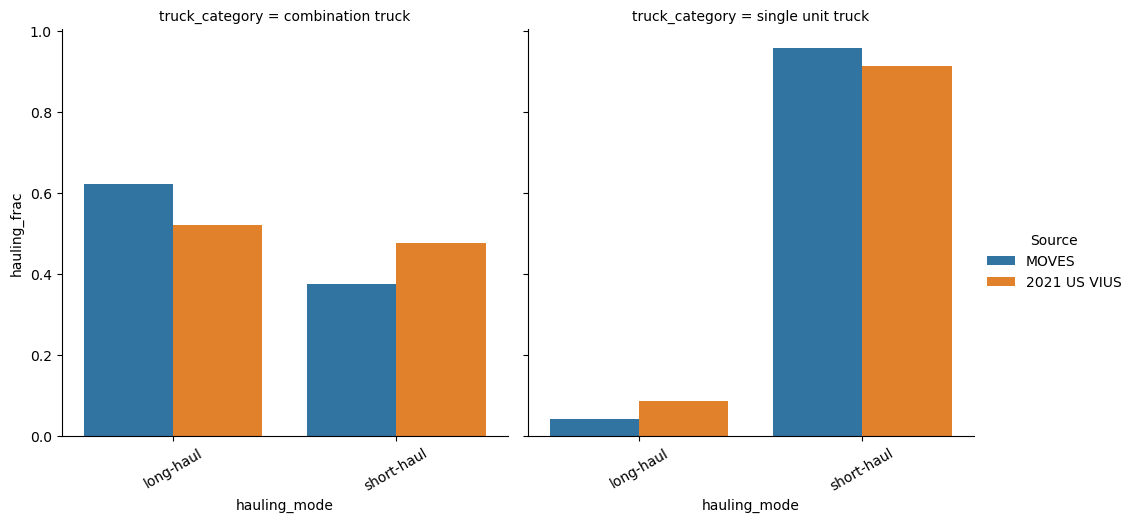

,Vehicle type,Count,Source,truck_category,hauling_mode,hauling_frac
0,combination long-haul truck,1811108.0,MOVES,combination truck,long-haul,0.623996
1,combination short-haul truck,1091325.0,MOVES,combination truck,short-haul,0.376004
3,single unit long-haul truck,383855.0,MOVES,single unit truck,long-haul,0.042241
4,single unit short-haul truck,8703350.0,MOVES,single unit truck,short-haul,0.957759
0,combination long-haul truck,1057993.1,2021 US VIUS,combination truck,long-haul,0.522045
1,combination short-haul truck,968638.8,2021 US VIUS,combination truck,short-haul,0.477955
3,single unit long-haul truck,392897.9,2021 US VIUS,single unit truck,long-haul,0.085961
4,single unit short-haul truck,4177755.3,2021 US VIUS,single unit truck,short-haul,0.914039


In [11]:
# hauling fraction by category

# drop LDT
truck_count_comparison = \
truck_count_comparison.loc[truck_count_comparison["Vehicle type"] != 
'light commercial truck']
truck_count_comparison.loc[:, 'truck_category'] =\
truck_count_comparison.loc[:, 'Vehicle type'].map(sut_ct_label)
truck_count_comparison.loc[:, 'hauling_mode'] =\
truck_count_comparison.loc[:, 'Vehicle type'].map(hauling_label)

truck_count_comparison.loc[:, 'hauling_frac'] = \
truck_count_comparison.loc[:, 'Count'] /\
truck_count_comparison.groupby(['Source', 'truck_category'])['Count'].transform('sum')

ax = sns.catplot(truck_count_comparison, 
            x="hauling_mode", y="hauling_frac", 
            hue="Source", col = 'truck_category', kind = 'bar',
            errorbar = None)
# plt.xticks(rotation = 30, ha= 'right')
for axn in ax.axes.flat:
    for label in axn.get_xticklabels():
        label.set_rotation(30)
plt.savefig('RawData/MOVES/plot/truck_hauling_frac_by_type.png',
            dpi = 300, bbox_inches = 'tight')
plt.show()
truck_count_comparison

# Part 1.2 - truck VMT comparison and hauling fraction

In [12]:
# compare veh VMT by MOVES source type
veh_name_remap = {'combination long-haul truck':'combination long-haul truck',
                  'combination short-haul truck': 'combination short-haul truck',
                  'single-unit short-haul truck': 'single unit short-haul truck',
                 'single-unit long-haul truck': 'single unit long-haul truck',
                  'light commercial truck':  'light commercial truck'}
# MOVES_fleet.head(5)
MOVES_VMT_by_st = \
MOVES_fleet.groupby('sourceTypeName')[['vmt_fraction']].sum()
MOVES_VMT_by_st = MOVES_VMT_by_st.reset_index()
MOVES_VMT_by_st['sourceTypeName'] = \
MOVES_VMT_by_st['sourceTypeName'].str.lower()
print(MOVES_VMT_by_st['sourceTypeName'].unique())
# MOVES_count_by_st

vius_VMT_by_st = \
vius_fleet.groupby('VEH_CLASS_MOVES')[['WGT_VMT']].sum()
vius_VMT_by_st = vius_VMT_by_st.reset_index()
vius_VMT_by_st['VEH_CLASS_MOVES'] = \
vius_VMT_by_st['VEH_CLASS_MOVES'].str.lower()
vius_VMT_by_st.loc[:, 'VEH_CLASS_MOVES'] = \
vius_VMT_by_st.loc[:, 'VEH_CLASS_MOVES'].map(veh_name_remap)

# generate veh count comparison
MOVES_VMT_by_st.columns = ['Vehicle type', 'VMT rate']
MOVES_VMT_by_st.loc[:, 'Source'] = 'MOVES'

vius_VMT_by_st.columns = ['Vehicle type', 'VMT rate']
vius_VMT_by_st.loc[:, 'Source'] = '2021 US VIUS'

['combination long-haul truck' 'combination short-haul truck'
 'light commercial truck' 'single unit long-haul truck'
 'single unit short-haul truck']


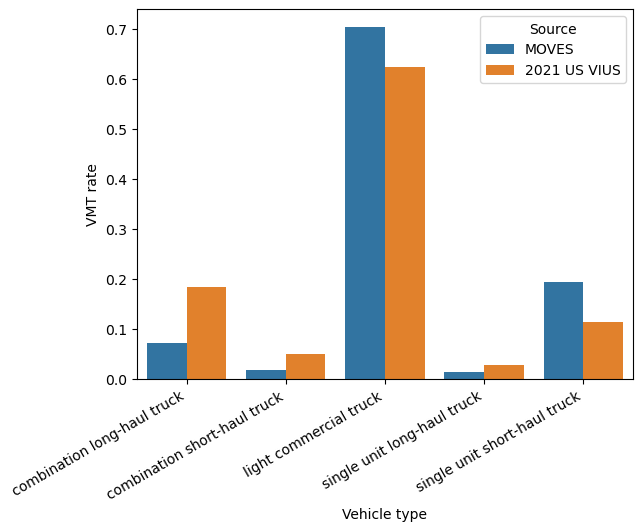

In [16]:
truck_VMT_comparison = \
pd.concat([MOVES_VMT_by_st, vius_VMT_by_st])
truck_VMT_comparison.loc[:, 'VMT rate'] = \
truck_VMT_comparison.loc[:, 'VMT rate'] /\
truck_VMT_comparison.groupby(['Source'])['VMT rate'].transform('sum')
truck_VMT_comparison.head(10)

sns.barplot(truck_VMT_comparison, 
            x="Vehicle type", y="VMT rate", hue="Source", 
            errorbar = None)
plt.xticks(rotation = 30, ha= 'right')
plt.savefig('RawData/MOVES/plot/truck_VMT_comparison_by_type.png',
            dpi = 300, bbox_inches = 'tight')
plt.show()

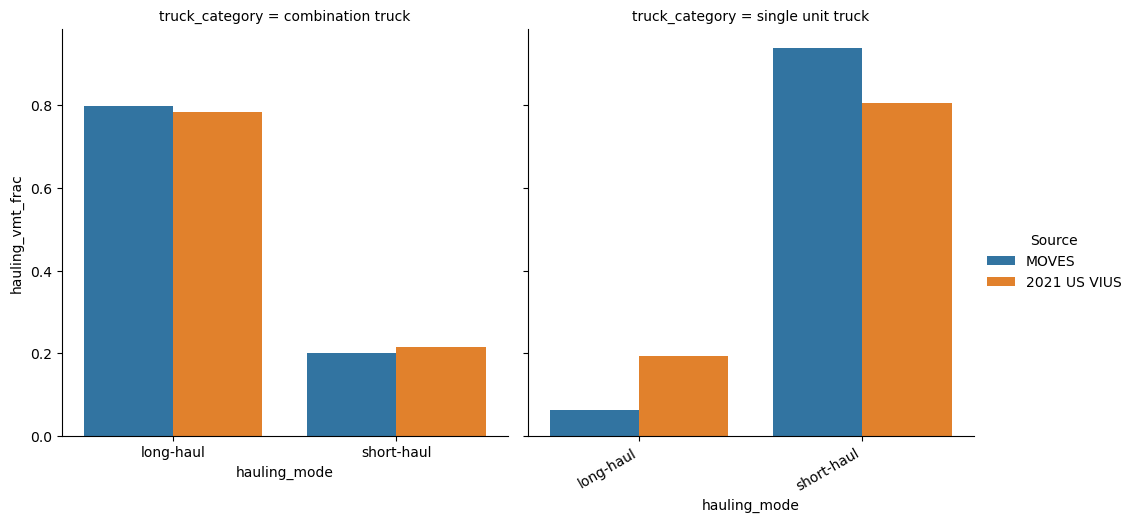

,Vehicle type,VMT rate,Source,truck_category,hauling_mode,hauling_vmt_frac
0,combination long-haul truck,7.223619e-02,MOVES,combination truck,long-haul,0.798135
1,combination short-haul truck,1.827009e-02,MOVES,combination truck,short-haul,0.201865
3,single unit long-haul truck,1.286612e-02,MOVES,single unit truck,long-haul,0.062540
4,single unit short-haul truck,1.928606e-01,MOVES,single unit truck,short-haul,0.937460
0,combination long-haul truck,9.567150e+10,2021 US VIUS,combination truck,long-haul,0.784705
1,combination short-haul truck,2.624889e+10,2021 US VIUS,combination truck,short-haul,0.215295
3,single unit long-haul truck,1.427704e+10,2021 US VIUS,single unit truck,long-haul,0.195017
4,single unit short-haul truck,5.893217e+10,2021 US VIUS,single unit truck,short-haul,0.804983


In [17]:
# hauling VMT fraction by category
truck_VMT_comparison = \
pd.concat([MOVES_VMT_by_st, vius_VMT_by_st])
truck_VMT_comparison = \
truck_VMT_comparison.loc[truck_VMT_comparison["Vehicle type"] != 
'light commercial truck']
truck_VMT_comparison.loc[:, 'truck_category'] =\
truck_VMT_comparison.loc[:, 'Vehicle type'].map(sut_ct_label)
truck_VMT_comparison.loc[:, 'hauling_mode'] =\
truck_VMT_comparison.loc[:, 'Vehicle type'].map(hauling_label)

truck_VMT_comparison.loc[:, 'hauling_vmt_frac'] = \
truck_VMT_comparison.loc[:, 'VMT rate'] /\
truck_VMT_comparison.groupby(['Source', 'truck_category'])['VMT rate'].transform('sum')

sns.catplot(truck_VMT_comparison, 
            x="hauling_mode", y="hauling_vmt_frac", 
            hue="Source", col = 'truck_category', kind = 'bar',
            errorbar = None)
plt.xticks(rotation = 30, ha= 'right')
plt.savefig('RawData/MOVES/plot/truck_hauling_vmt_frac_by_type.png',
            dpi = 300, bbox_inches = 'tight')
plt.show()
truck_VMT_comparison

# Part 2.1 - truck type and age distribution by count

In [15]:
# compare veh count by MOVES source type and age bin

MOVES_fleet.head(5)
MOVES_count_by_st_age = \
MOVES_fleet.groupby(['sourceTypeName', 'AGE_BIN'])[['population_by_year']].sum()
MOVES_count_by_st_age = MOVES_count_by_st_age.reset_index()
MOVES_count_by_st_age['sourceTypeName'] = \
MOVES_count_by_st_age['sourceTypeName'].str.lower()
print(MOVES_count_by_st_age['sourceTypeName'].unique())
# MOVES_count_by_st

vius_count_by_st_age = \
vius_fleet.groupby(['VEH_CLASS_MOVES', 'AGE_BIN'])[['TABWEIGHT']].sum()
vius_count_by_st_age = vius_count_by_st_age.reset_index()
vius_count_by_st_age['VEH_CLASS_MOVES'] = \
vius_count_by_st_age['VEH_CLASS_MOVES'].str.lower()
vius_count_by_st_age.loc[:, 'VEH_CLASS_MOVES'] = \
vius_count_by_st_age.loc[:, 'VEH_CLASS_MOVES'].map(veh_name_remap)

# generate veh count comparison
MOVES_count_by_st_age.columns = ['Vehicle type', 'Age bin', 'Fraction']
MOVES_count_by_st_age.loc[:, 'Source'] = 'MOVES'
MOVES_count_by_st_age.loc[:, 'Fraction'] = \
MOVES_count_by_st_age.loc[:, 'Fraction']/ \
MOVES_count_by_st_age.groupby('Vehicle type')['Fraction'].transform('sum')

vius_count_by_st_age.columns = ['Vehicle type', 'Age bin', 'Fraction']
vius_count_by_st_age.loc[:, 'Source'] = '2021 US VIUS'
vius_count_by_st_age.loc[:, 'Fraction'] = \
vius_count_by_st_age.loc[:, 'Fraction']/ \
vius_count_by_st_age.groupby('Vehicle type')['Fraction'].transform('sum')

vius_count_by_st_age.head(5)

['combination long-haul truck' 'combination short-haul truck'
 'light commercial truck' 'single unit long-haul truck'
 'single unit short-haul truck']


,Vehicle type,Age bin,Fraction,Source
0,combination long-haul truck,14<age<=19,0.059992,2021 US VIUS
1,combination long-haul truck,3<age<=5,0.158874,2021 US VIUS
2,combination long-haul truck,5<age<=7,0.102819,2021 US VIUS
3,combination long-haul truck,7<age<=9,0.075193,2021 US VIUS
4,combination long-haul truck,9<age<=14,0.089670,2021 US VIUS


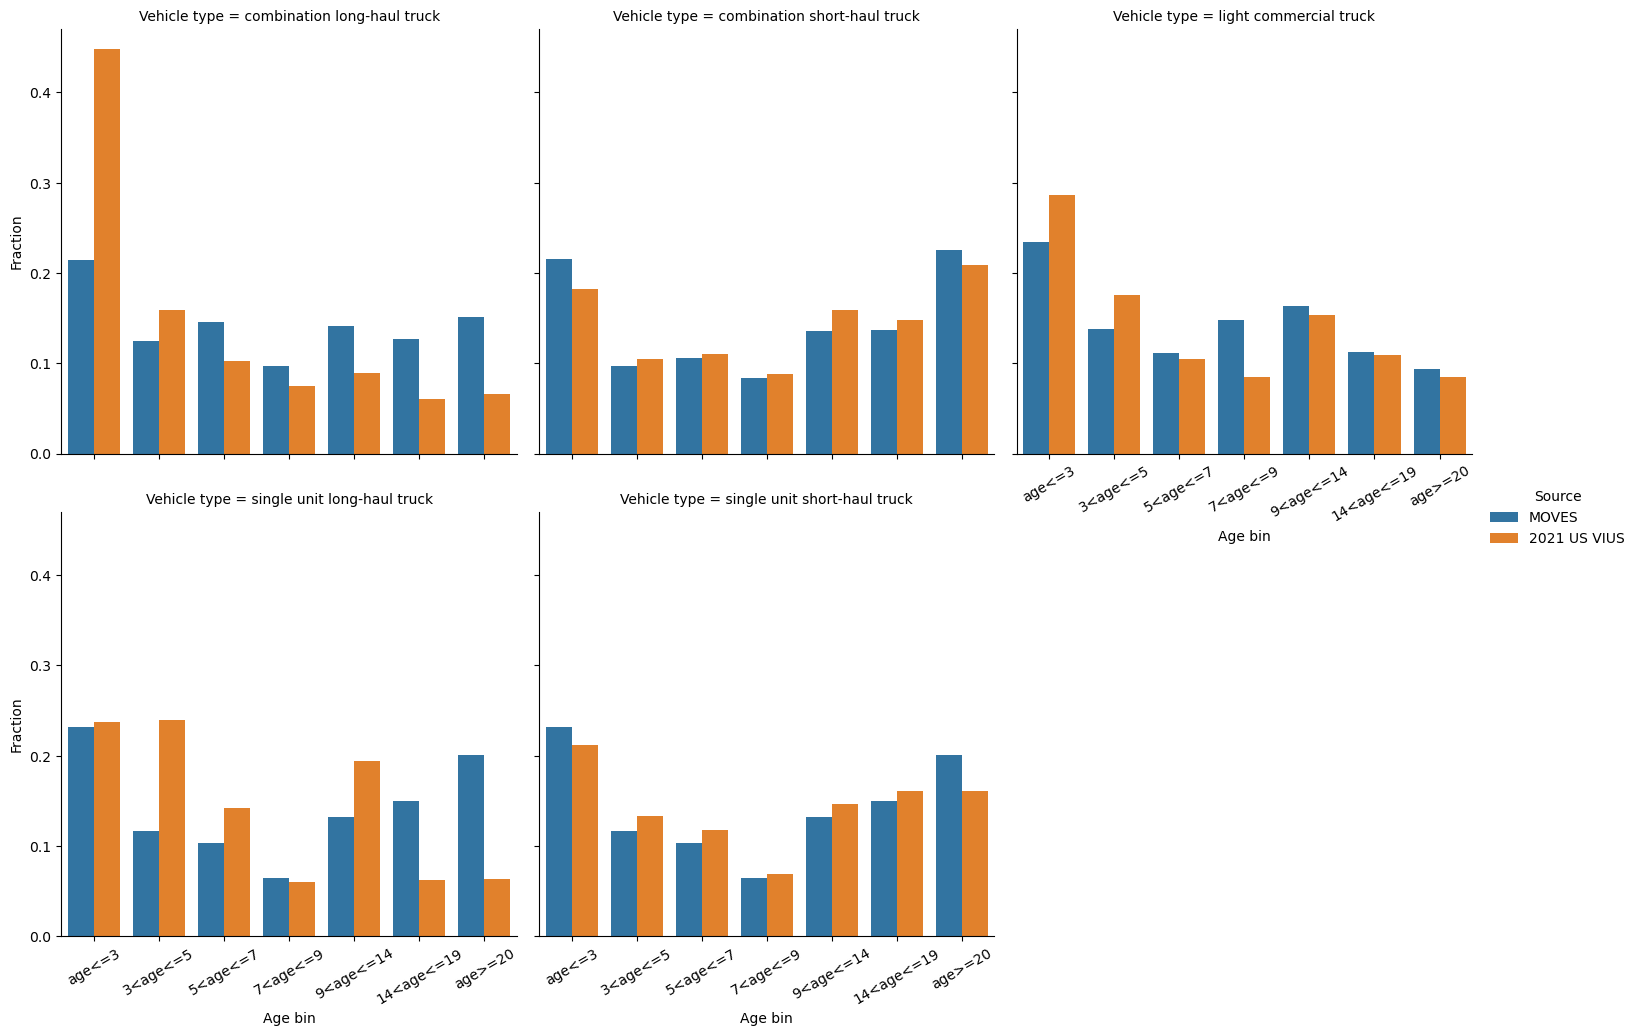

In [16]:
#plot age distribution
truck_count_comparison_by_age = \
pd.concat([MOVES_count_by_st_age, vius_count_by_st_age])
# truck_count_comparison_by_age = \
# truck_count_comparison_by_age.loc[truck_count_comparison_by_age["Vehicle type"] != 
# 'light commercial truck']
g = sns.catplot(truck_count_comparison_by_age, 
            x="Age bin", y="Fraction", hue="Source", 
            kind = 'bar', col = 'Vehicle type',
            col_wrap = 3)
for axn in g.axes.flat:
    for label in axn.get_xticklabels():
        label.set_rotation(30)
# g.set_xticklabels(rotation = 30, ha= 'right')
plt.savefig('RawData/MOVES/plot/truck_count_comparison_by_age.png',
            dpi = 300, bbox_inches = 'tight')
plt.show()

# Part 2.2 - truck type and age distribution by VMT

In [17]:
# compare veh VMT by MOVES source type and age bin

MOVES_fleet.head(5)
MOVES_VMT_by_st_age = \
MOVES_fleet.groupby(['sourceTypeName', 'AGE_BIN'])[['vmt_fraction']].sum()
MOVES_VMT_by_st_age = MOVES_VMT_by_st_age.reset_index()
MOVES_VMT_by_st_age['sourceTypeName'] = \
MOVES_VMT_by_st_age['sourceTypeName'].str.lower()
print(MOVES_VMT_by_st_age['sourceTypeName'].unique())
# MOVES_count_by_st

vius_VMT_by_st_age = \
vius_fleet.groupby(['VEH_CLASS_MOVES', 'AGE_BIN'])[['WGT_VMT']].sum()
vius_VMT_by_st_age = vius_VMT_by_st_age.reset_index()
vius_VMT_by_st_age['VEH_CLASS_MOVES'] = \
vius_VMT_by_st_age['VEH_CLASS_MOVES'].str.lower()
vius_VMT_by_st_age.loc[:, 'VEH_CLASS_MOVES'] = \
vius_VMT_by_st_age.loc[:, 'VEH_CLASS_MOVES'].map(veh_name_remap)

# generate veh count comparison
MOVES_VMT_by_st_age.columns = ['Vehicle type', 'Age bin', 'VMT fraction']
MOVES_VMT_by_st_age.loc[:, 'Source'] = 'MOVES'
MOVES_VMT_by_st_age.loc[:, 'VMT fraction'] = \
MOVES_VMT_by_st_age.loc[:, 'VMT fraction']/ \
MOVES_VMT_by_st_age.groupby('Vehicle type')['VMT fraction'].transform('sum')

vius_VMT_by_st_age.columns = ['Vehicle type', 'Age bin', 'VMT fraction']
vius_VMT_by_st_age.loc[:, 'Source'] = '2021 US VIUS'
vius_VMT_by_st_age.loc[:, 'VMT fraction'] = \
vius_VMT_by_st_age.loc[:, 'VMT fraction']/ \
vius_VMT_by_st_age.groupby('Vehicle type')['VMT fraction'].transform('sum')

vius_VMT_by_st_age.head(5)

['combination long-haul truck' 'combination short-haul truck'
 'light commercial truck' 'single unit long-haul truck'
 'single unit short-haul truck']


,Vehicle type,Age bin,VMT fraction,Source
0,combination long-haul truck,14<age<=19,0.043559,2021 US VIUS
1,combination long-haul truck,3<age<=5,0.160079,2021 US VIUS
2,combination long-haul truck,5<age<=7,0.091620,2021 US VIUS
3,combination long-haul truck,7<age<=9,0.063170,2021 US VIUS
4,combination long-haul truck,9<age<=14,0.080002,2021 US VIUS


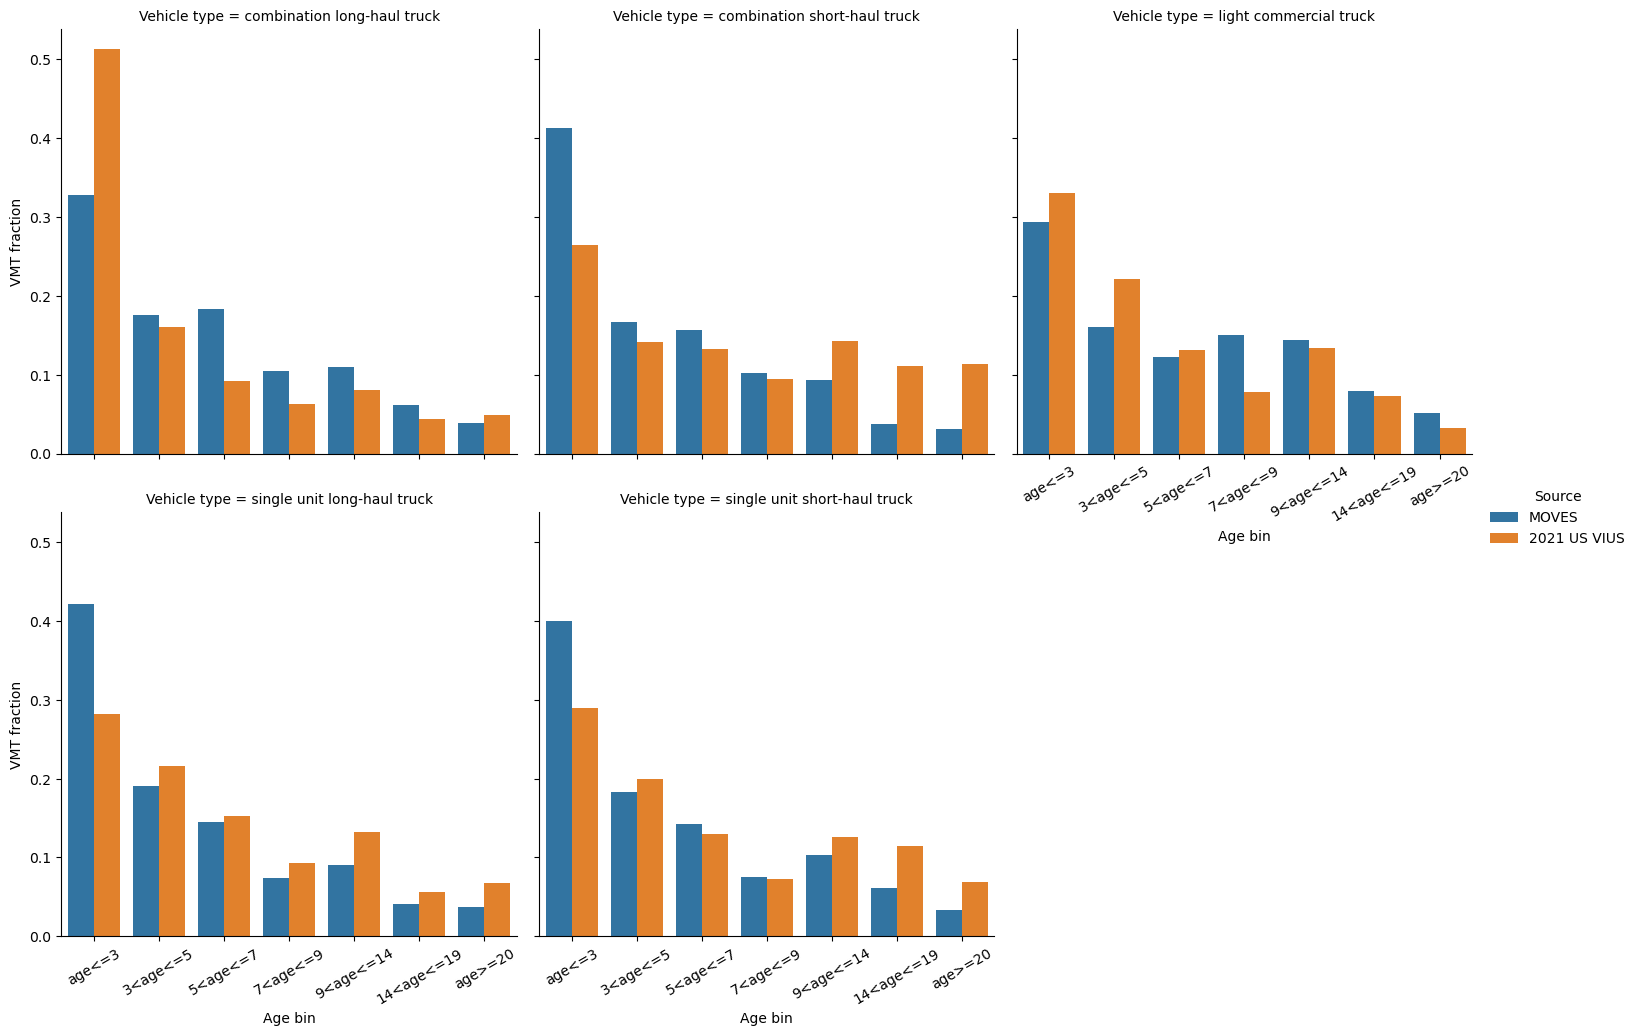

In [18]:
#plot age distribution BY vmt
truck_VMT_comparison_by_age = \
pd.concat([MOVES_VMT_by_st_age, vius_VMT_by_st_age])
# truck_VMT_comparison_by_age = \
# truck_VMT_comparison_by_age.loc[truck_VMT_comparison_by_age["Vehicle type"] != 
# 'light commercial truck']
g = sns.catplot(truck_VMT_comparison_by_age, 
            x="Age bin", y="VMT fraction", hue="Source", 
            kind = 'bar', col = 'Vehicle type',
            col_wrap = 3)
for axn in g.axes.flat:
    for label in axn.get_xticklabels():
        label.set_rotation(30)
# g.set_xticklabels(rotation = 30, ha= 'right')
plt.savefig('RawData/MOVES/plot/truck_VMT_comparison_by_age.png',
            dpi = 300, bbox_inches = 'tight')
plt.show()

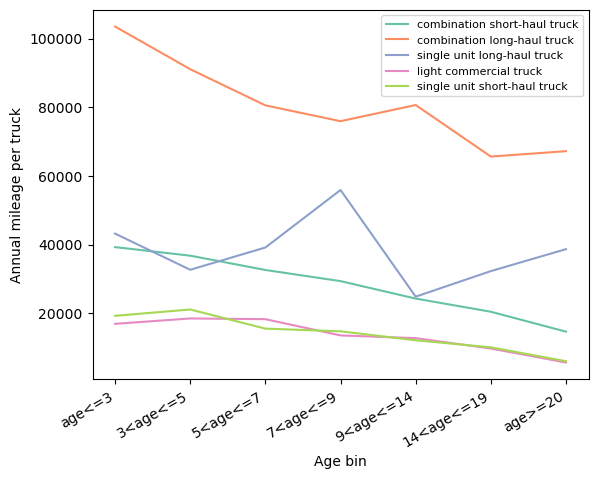

In [19]:
# VIUS VMT/truck

vius_stats_by_st_age = \
vius_fleet.groupby(['VEH_CLASS_MOVES', 'AGE_BIN'])[['TABWEIGHT','WGT_VMT']].sum()
vius_stats_by_st_age = vius_stats_by_st_age.reset_index()
vius_stats_by_st_age.loc[:, 'AGE_ORDER'] = \
vius_stats_by_st_age.loc[:, 'AGE_BIN'].map(age_bin_order)

vius_stats_by_st_age = \
vius_stats_by_st_age.sort_values(by = 'AGE_ORDER', ascending = True)
vius_stats_by_st_age['VEH_CLASS_MOVES'] = \
vius_stats_by_st_age['VEH_CLASS_MOVES'].str.lower()
vius_stats_by_st_age.loc[:, 'VEH_CLASS_MOVES'] = \
vius_stats_by_st_age.loc[:, 'VEH_CLASS_MOVES'].map(veh_name_remap)


vius_stats_by_st_age.loc[:, 'ANNUAL_MILE_PER_TRUCK'] = \
vius_stats_by_st_age.loc[:, 'WGT_VMT'] / \
vius_stats_by_st_age.loc[:, 'TABWEIGHT']
sns.lineplot(vius_stats_by_st_age, 
            x="AGE_BIN", y="ANNUAL_MILE_PER_TRUCK", palette = 'Set2',
            hue="VEH_CLASS_MOVES", 
            errorbar = None)
plt.xticks(rotation = 30, ha= 'right')
plt.xlabel('Age bin')
plt.ylabel('Annual mileage per truck')
plt.legend(fontsize = 8, loc = 1)
plt.savefig('RawData/MOVES/plot/VIUS_VMT_per_truck_by_type_age.png',
            dpi = 300, bbox_inches = 'tight')
plt.show()

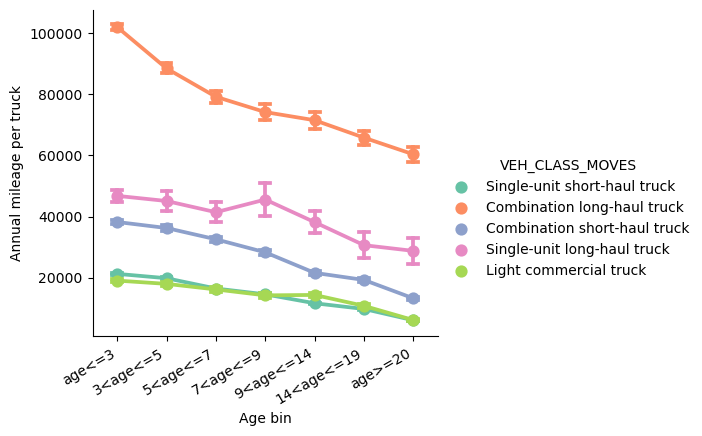

In [21]:
vius_fleet = \
vius_fleet.sort_values(by = 'VEH_AGE', ascending = True)
sns.catplot(x="AGE_BIN", y="MILESANNL",
             hue="VEH_CLASS_MOVES", 
             data=vius_fleet, capsize=.2, palette = 'Set2',
            errorbar="se", kind="point", height=4, aspect=1.25,)
plt.xticks(rotation = 30, ha= 'right')
plt.xlabel('Age bin')
plt.ylabel('Annual mileage per truck')
plt.savefig('RawData/MOVES/plot/VIUS_VMT_distribution_by_type_age.png',
            dpi = 300, bbox_inches = 'tight')
plt.show()

# Part 3.1 - truck type and fuel distribution by count

In [38]:
print(len(vius_fleet))
vius_fleet.groupby(['VEH_CLASS_MOVES']).size()


36980


VEH_CLASS_MOVES
Combination long-haul truck      6100
Combination short-haul truck     6513
Light commercial truck           2934
Single-unit long-haul truck      1546
Single-unit short-haul truck    19887
dtype: int64

In [7]:
MOVES_fuel_lookup = {1: 'Gasoline', 
                    2: 'Diesel',
                    3: 'CNG',
                    5: 'Other',
                    9: 'Electricity'}

VIUS_fuel_lookup = {'Gasoline': 'Gasoline', 
                    'Diesel': 'Diesel',
                    'Compressed natural gas': 'CNG',
                    'Propane': 'Other',
                    'Combination': 'Other',
                    'Liquified natural gas': 'Other',
                    'Alcohol fuels': 'Other',
                    'Electricity': 'Electricity'}
print(MOVES_fleet.fuelTypeID.unique())
# 1- gas, 2 - diesel, 3 - CNG, 5 - E-85, 9 - elec
print(vius_fleet.FUELTYPE.unique())

vius_fleet_with_fuel = \
vius_fleet.loc[vius_fleet['FUELTYPE'] != 'Not reported']
print(len(vius_fleet_with_fuel))
vius_fleet_with_fuel.loc[:, 'fuelTypeName'] = \
vius_fleet_with_fuel.loc[:, 'FUELTYPE'].map(VIUS_fuel_lookup)

MOVES_fleet.loc[:, 'fuelTypeName'] = \
MOVES_fleet.loc[:, 'fuelTypeID'].map(MOVES_fuel_lookup)

print(vius_fleet_with_fuel['fuelTypeName'].unique())
print(MOVES_fleet['fuelTypeName'].unique())

[1 2 5 9 3]
['Diesel' 'Gasoline' 'Compressed natural gas' 'Not reported' 'Combination'
 'Alcohol fuels' 'Propane' 'Electricity' 'Liquified natural gas']
36311
['Diesel' 'Gasoline' 'CNG' 'Other' 'Electricity']
['Gasoline' 'Diesel' 'Other' 'Electricity' 'CNG']


In [10]:
# compare fuel type
MOVES_fleet.loc[:, 'population_year_fuel'] = \
MOVES_fleet.loc[:, 'population_by_year'] * MOVES_fleet.loc[:, 'stmyFraction']
MOVES_count_by_st_fuel = \
MOVES_fleet.groupby(['sourceTypeName', 'fuelTypeName'])[['population_year_fuel']].sum()
MOVES_count_by_st_fuel = MOVES_count_by_st_fuel.reset_index()
MOVES_count_by_st_fuel['sourceTypeName'] = \
MOVES_count_by_st_fuel['sourceTypeName'].str.lower()
print(MOVES_count_by_st_fuel['sourceTypeName'].unique())
# MOVES_count_by_st

vius_count_by_st_fuel = \
vius_fleet_with_fuel.groupby(['VEH_CLASS_MOVES', 'fuelTypeName'])[['TABWEIGHT']].sum()
vius_count_by_st_fuel = vius_count_by_st_fuel.reset_index()
vius_count_by_st_fuel['VEH_CLASS_MOVES'] = \
vius_count_by_st_fuel['VEH_CLASS_MOVES'].str.lower()
vius_count_by_st_fuel.loc[:, 'VEH_CLASS_MOVES'] = \
vius_count_by_st_fuel.loc[:, 'VEH_CLASS_MOVES'].map(veh_name_remap)

# generate veh count comparison
MOVES_count_by_st_fuel.columns = ['Vehicle type', 'Fuel type', 'Fraction']
MOVES_count_by_st_fuel.loc[:, 'Source'] = 'MOVES'
MOVES_count_by_st_fuel.loc[:, 'Fraction'] = \
MOVES_count_by_st_fuel.loc[:, 'Fraction']/ \
MOVES_count_by_st_fuel.groupby('Vehicle type')['Fraction'].transform('sum')

vius_count_by_st_fuel.columns = ['Vehicle type', 'Fuel type', 'Fraction']
vius_count_by_st_fuel.loc[:, 'Source'] = '2021 US VIUS'
vius_count_by_st_fuel.loc[:, 'Fraction'] = \
vius_count_by_st_fuel.loc[:, 'Fraction']/ \
vius_count_by_st_fuel.groupby('Vehicle type')['Fraction'].transform('sum')

vius_count_by_st_fuel.head(5)

['combination long-haul truck' 'combination short-haul truck'
 'light commercial truck' 'single unit long-haul truck'
 'single unit short-haul truck']


,Vehicle type,Fuel type,Fraction,Source
0,combination long-haul truck,CNG,0.004329,2021 US VIUS
1,combination long-haul truck,Diesel,0.994094,2021 US VIUS
2,combination long-haul truck,Gasoline,0.000177,2021 US VIUS
3,combination long-haul truck,Other,0.001401,2021 US VIUS
4,combination short-haul truck,CNG,0.003049,2021 US VIUS


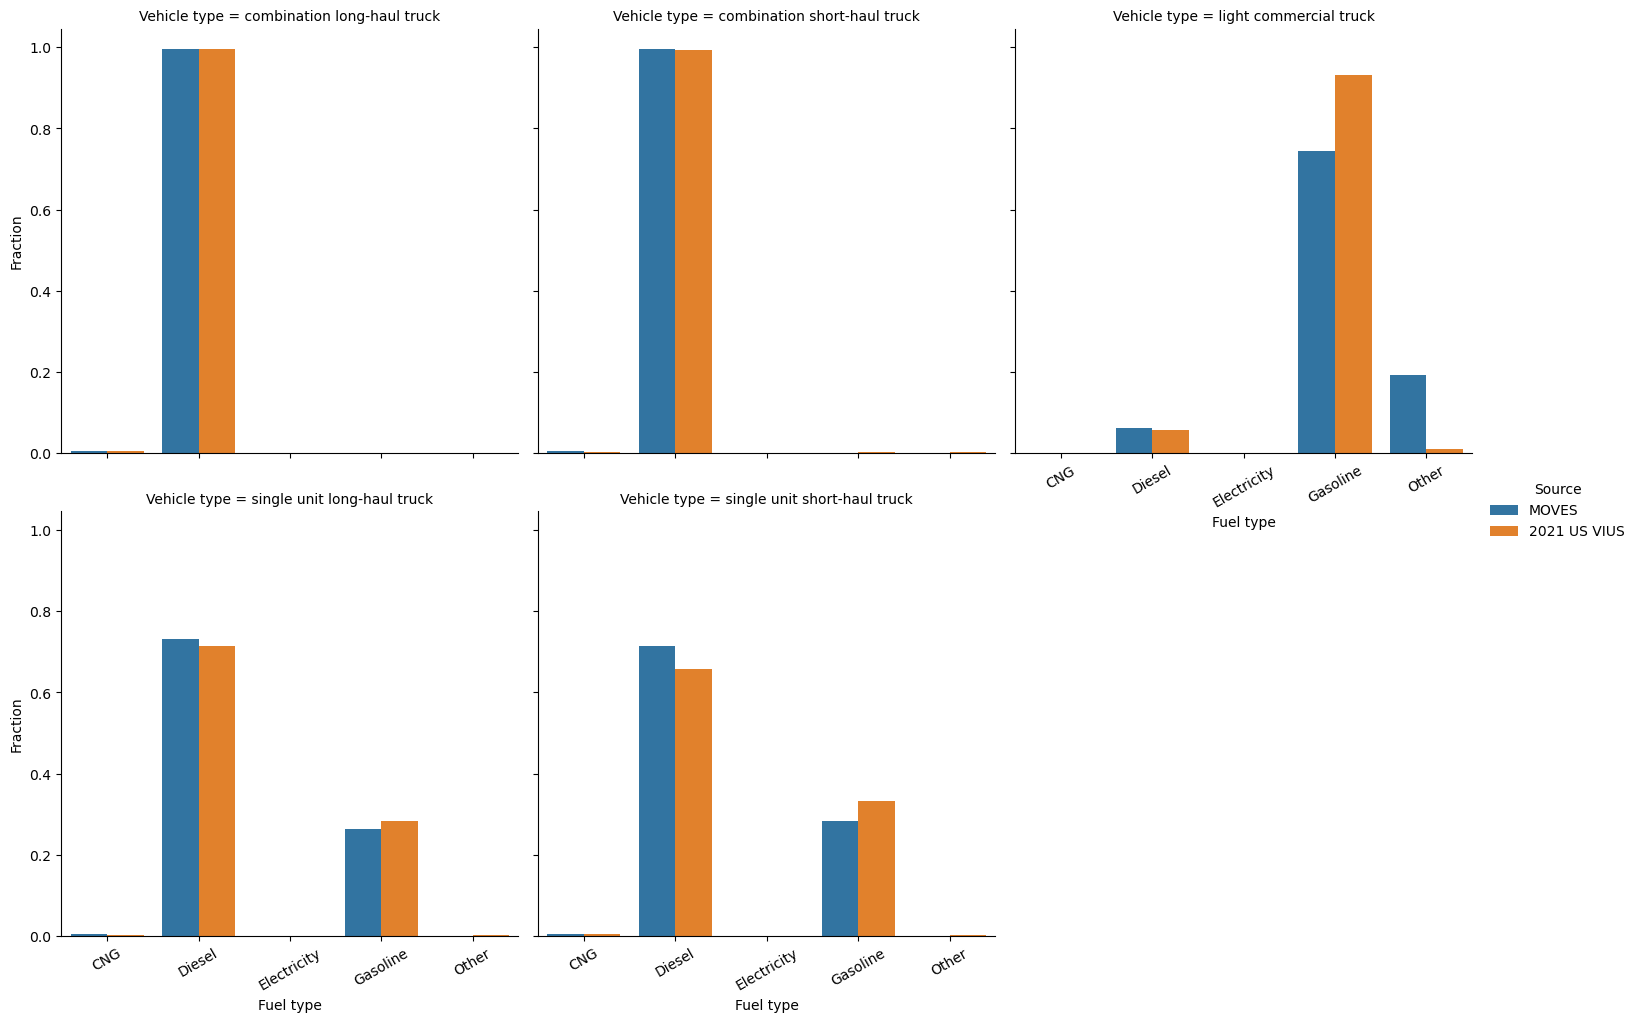

In [11]:
truck_count_comparison_by_fuel = \
pd.concat([MOVES_count_by_st_fuel, vius_count_by_st_fuel])
# truck_count_comparison_by_age = \
# truck_count_comparison_by_age.loc[truck_count_comparison_by_age["Vehicle type"] != 
# 'light commercial truck']
g = sns.catplot(truck_count_comparison_by_fuel, 
            x="Fuel type", y="Fraction", hue="Source", 
            kind = 'bar', col = 'Vehicle type',
            col_wrap = 3)
for axn in g.axes.flat:
    for label in axn.get_xticklabels():
        label.set_rotation(30)
# g.set_xticklabels(rotation = 30, ha= 'right')
plt.savefig('RawData/MOVES/plot/truck_count_comparison_by_fuel.png',
            dpi = 300, bbox_inches = 'tight')
plt.show()

# Part 3.2 - truck type and fuel distribution by VMT

In [12]:
# VMT by fuel type
MOVES_VMT_by_st_fuel = \
MOVES_fleet.groupby(['sourceTypeName', 'fuelTypeName'])[['vmt_fraction']].sum()
MOVES_VMT_by_st_fuel = MOVES_VMT_by_st_fuel.reset_index()
MOVES_VMT_by_st_fuel['sourceTypeName'] = \
MOVES_VMT_by_st_fuel['sourceTypeName'].str.lower()
print(MOVES_VMT_by_st_fuel['sourceTypeName'].unique())
# MOVES_count_by_st

vius_VMT_by_st_fuel = \
vius_fleet_with_fuel.groupby(['VEH_CLASS_MOVES', 'fuelTypeName'])[['WGT_VMT']].sum()
vius_VMT_by_st_fuel = vius_VMT_by_st_fuel.reset_index()
vius_VMT_by_st_fuel['VEH_CLASS_MOVES'] = \
vius_VMT_by_st_fuel['VEH_CLASS_MOVES'].str.lower()
vius_VMT_by_st_fuel.loc[:, 'VEH_CLASS_MOVES'] = \
vius_VMT_by_st_fuel.loc[:, 'VEH_CLASS_MOVES'].map(veh_name_remap)

# generate veh count comparison
MOVES_VMT_by_st_fuel.columns = ['Vehicle type', 'Fuel type', 'VMT Fraction']
MOVES_VMT_by_st_fuel.loc[:, 'Source'] = 'MOVES'
MOVES_VMT_by_st_fuel.loc[:, 'VMT Fraction'] = \
MOVES_VMT_by_st_fuel.loc[:, 'VMT Fraction']/ \
MOVES_VMT_by_st_fuel.groupby('Vehicle type')['VMT Fraction'].transform('sum')

vius_VMT_by_st_fuel.columns = ['Vehicle type', 'Fuel type', 'VMT Fraction']
vius_VMT_by_st_fuel.loc[:, 'Source'] = '2021 US VIUS'
vius_VMT_by_st_fuel.loc[:, 'VMT Fraction'] = \
vius_VMT_by_st_fuel.loc[:, 'VMT Fraction']/ \
vius_VMT_by_st_fuel.groupby('Vehicle type')['VMT Fraction'].transform('sum')

vius_VMT_by_st_fuel.head(5)

['combination long-haul truck' 'combination short-haul truck'
 'light commercial truck' 'single unit long-haul truck'
 'single unit short-haul truck']


,Vehicle type,Fuel type,VMT Fraction,Source
0,combination long-haul truck,CNG,0.005716,2021 US VIUS
1,combination long-haul truck,Diesel,0.992965,2021 US VIUS
2,combination long-haul truck,Gasoline,0.000102,2021 US VIUS
3,combination long-haul truck,Other,0.001217,2021 US VIUS
4,combination short-haul truck,CNG,0.004731,2021 US VIUS


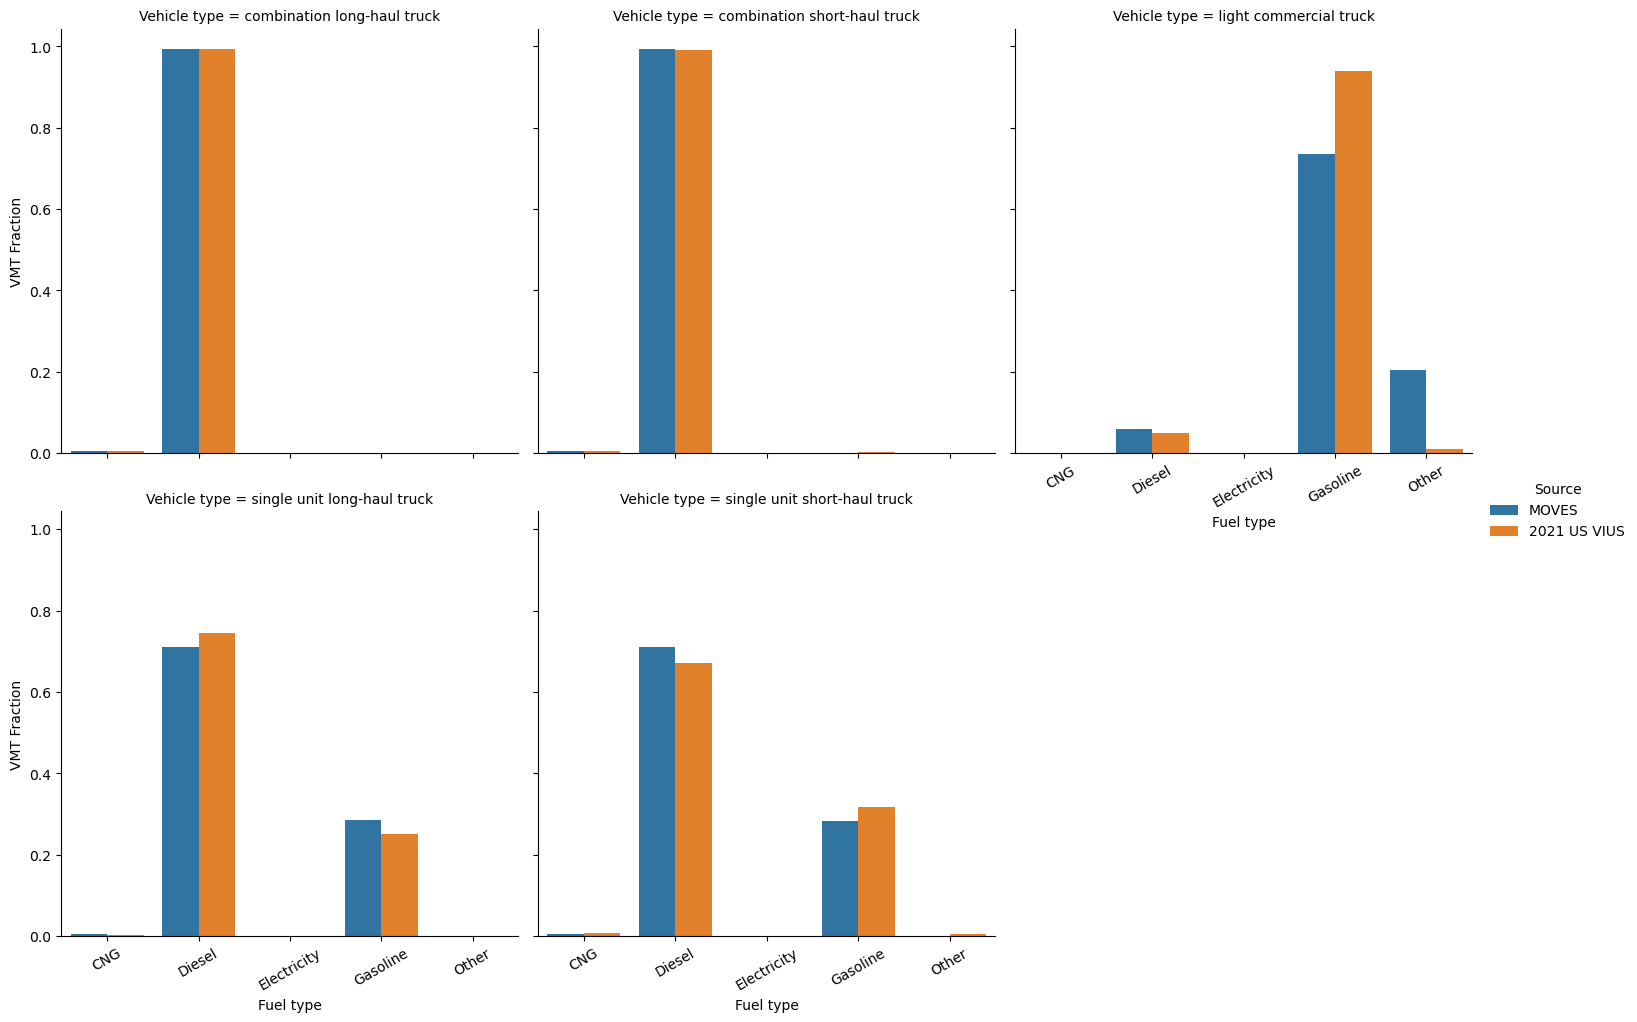

In [14]:
#plot fuel type distribution BY vmt
truck_VMT_comparison_by_fuel = \
pd.concat([MOVES_VMT_by_st_fuel, vius_VMT_by_st_fuel])
# truck_VMT_comparison_by_age = \
# truck_VMT_comparison_by_age.loc[truck_VMT_comparison_by_age["Vehicle type"] != 
# 'light commercial truck']
g = sns.catplot(truck_VMT_comparison_by_fuel, 
            x="Fuel type", y="VMT Fraction", hue="Source", 
            kind = 'bar', col = 'Vehicle type',
            col_wrap = 3)
for axn in g.axes.flat:
    for label in axn.get_xticklabels():
        label.set_rotation(30)
# g.set_xticklabels(rotation = 30, ha= 'right')
plt.savefig('RawData/MOVES/plot/truck_VMT_comparison_by_fuel.png',
            dpi = 300, bbox_inches = 'tight')
plt.show()